# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    #filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
    #kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
    #strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    #padding: one of "valid" or "same" (case-insensitive).
    #activation: Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).            
    
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    #filters: Integer, the dimensionality of the output space
    #strides: Integer, the stride values for all spatial dimensions
    #defaults to kernel size of 3 
    #conv1 = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [8]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    print('small_ip_layer shape: ', small_ip_layer.get_shape().as_list())
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    small_ip_layer_upsampled = bilinear_upsample(small_ip_layer)
    print('small_ip_layer_upsampled shape: ', small_ip_layer_upsampled.get_shape().as_list())
    print('large_ip_layer shape: ', large_ip_layer.get_shape().as_list())
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    cat_layers = layers.concatenate([small_ip_layer_upsampled, large_ip_layer])
    print('cat_layers shape: ', cat_layers.get_shape().as_list())
    # TODO Add some number of separable convolution layers
    conv1 = separable_conv2d_batchnorm(cat_layers, filters=filters, strides=1)
    output_layer = separable_conv2d_batchnorm(conv1, filters=filters, strides=1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [13]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    #filters: Integer, the dimensionality of the output space
    #strides: Integer, the stride values for all spatial dimensions
    filters1 = 10
    enc_layer1 = encoder_block(inputs, filters=10, strides=1)
    print('enc_layer1 shape: ', enc_layer1.get_shape().as_list())
    enc_layer2 = encoder_block(enc_layer1, filters=20, strides=2)
    print('enc_layer2 shape: ', enc_layer2.get_shape().as_list())
    enc_layer2 = encoder_block(enc_layer1, filters=30, strides=2)
    print('enc_layer2 shape: ', enc_layer2.get_shape().as_list())
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    #filters: Integer, the dimensionality of the output space (i.e. the number of filters in the convolution).
    conv_1x1 = conv2d_batchnorm(enc_layer2, filters=60, kernel_size=1, strides=1)
    print('conv_1x1 shape: ', conv_1x1.get_shape().as_list())
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
    decode_layer1 = decoder_block(conv_1x1, enc_layer1, filters=40)
    print('decode_layer1 shape: ', decode_layer1.get_shape().as_list())
    decode_layer2 = decoder_block(enc_layer2, decode_layer1, filters=30)
    print('decode_layer2 shape: ', decode_layer2.get_shape().as_list())
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(filters=num_classes, kernel_size=1, activation='softmax', padding='same')(decode_layer2)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

enc_layer1 shape:  [None, 160, 160, 10]
enc_layer2 shape:  [None, 80, 80, 20]
enc_layer2 shape:  [None, 80, 80, 30]
conv_1x1 shape:  [None, 80, 80, 60]
small_ip_layer shape:  [None, 80, 80, 60]
small_ip_layer_upsampled shape:  [None, 160, 160, 60]
large_ip_layer shape:  [None, 160, 160, 10]
cat_layers shape:  [None, 160, 160, 70]
decode_layer1 shape:  [None, 160, 160, 40]
small_ip_layer shape:  [None, 80, 80, 30]
small_ip_layer_upsampled shape:  [None, 160, 160, 30]
large_ip_layer shape:  [None, 160, 160, 40]
cat_layers shape:  [None, 160, 160, 70]
decode_layer2 shape:  [None, 160, 160, 30]


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [15]:
learning_rate = 0.005
batch_size = 25
num_epochs = 100
steps_per_epoch = 100
validation_steps = 100
workers = 5

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 160, 160, 3)   0                                            
____________________________________________________________________________________________________
separable_conv2d_keras_22 (Separ (None, 160, 160, 10)  67          input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_25 (BatchNor (None, 160, 160, 10)  40          separable_conv2d_keras_22[0][0]  
____________________________________________________________________________________________________
separable_conv2d_keras_24 (Separ (None, 80, 80, 30)    420         batch_normalization_25[0][0]     
___________________________________________________________________________________________

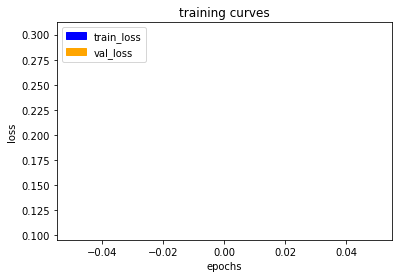

100/100 [==============================] - 80s - loss: 0.3024 - val_loss: 0.1053
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0592

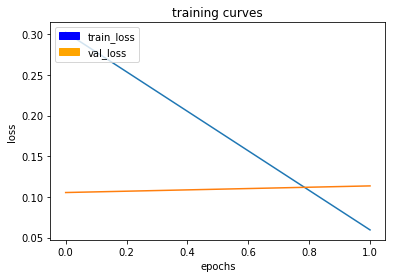

100/100 [==============================] - 76s - loss: 0.0592 - val_loss: 0.1135
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0523

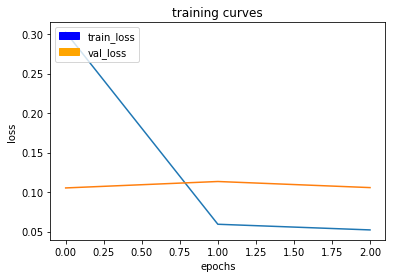

100/100 [==============================] - 77s - loss: 0.0522 - val_loss: 0.1057
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0498

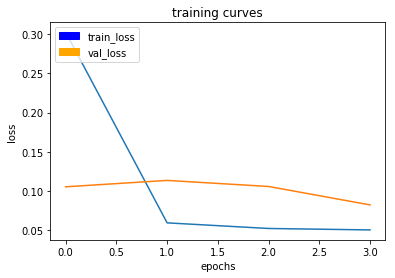

100/100 [==============================] - 77s - loss: 0.0502 - val_loss: 0.0822
Epoch 5/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0464

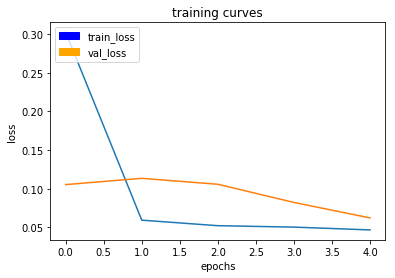

100/100 [==============================] - 76s - loss: 0.0466 - val_loss: 0.0622
Epoch 6/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0471

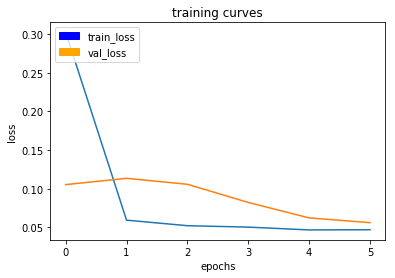

100/100 [==============================] - 77s - loss: 0.0470 - val_loss: 0.0561
Epoch 7/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0410

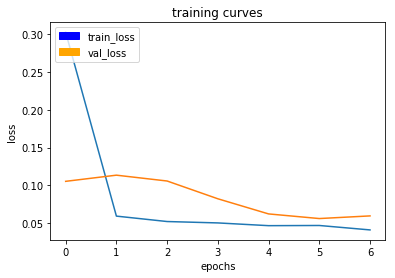

100/100 [==============================] - 77s - loss: 0.0411 - val_loss: 0.0596
Epoch 8/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0396

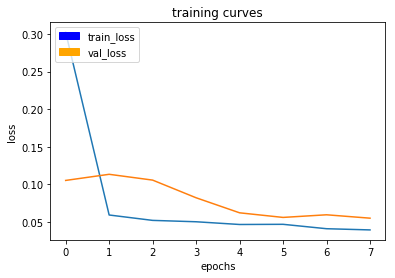

100/100 [==============================] - 77s - loss: 0.0395 - val_loss: 0.0551
Epoch 9/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0460

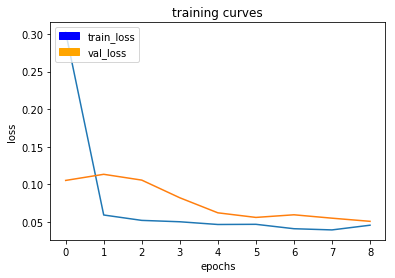

100/100 [==============================] - 76s - loss: 0.0458 - val_loss: 0.0509
Epoch 10/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0396

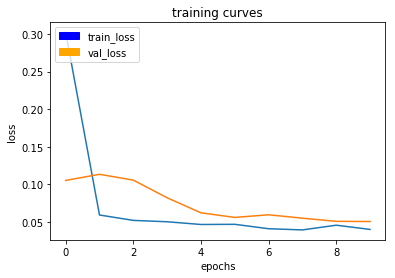

100/100 [==============================] - 76s - loss: 0.0400 - val_loss: 0.0507
Epoch 11/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0371

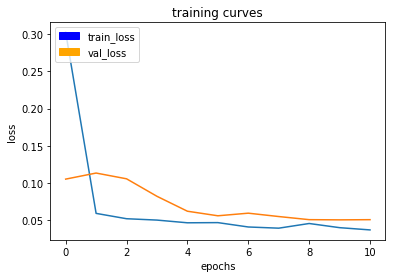

100/100 [==============================] - 77s - loss: 0.0372 - val_loss: 0.0509
Epoch 12/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0397

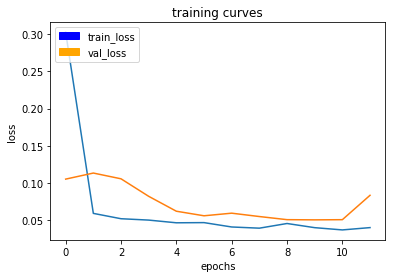

100/100 [==============================] - 76s - loss: 0.0402 - val_loss: 0.0836
Epoch 13/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0388

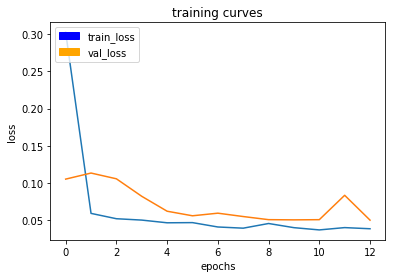

100/100 [==============================] - 77s - loss: 0.0387 - val_loss: 0.0503
Epoch 14/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0395

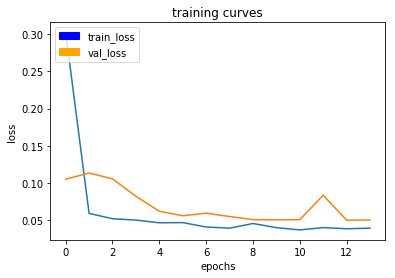

100/100 [==============================] - 77s - loss: 0.0395 - val_loss: 0.0504
Epoch 15/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0334

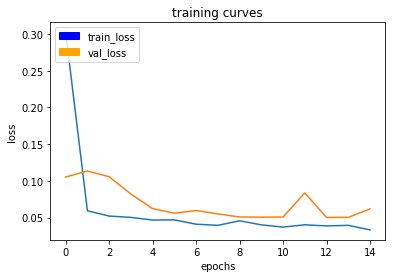

100/100 [==============================] - 76s - loss: 0.0334 - val_loss: 0.0619
Epoch 16/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0330

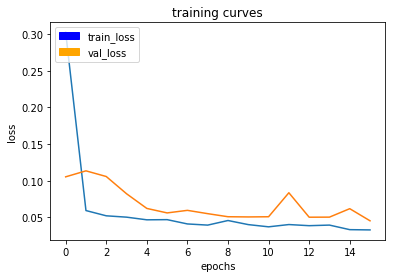

100/100 [==============================] - 77s - loss: 0.0330 - val_loss: 0.0454
Epoch 17/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0383

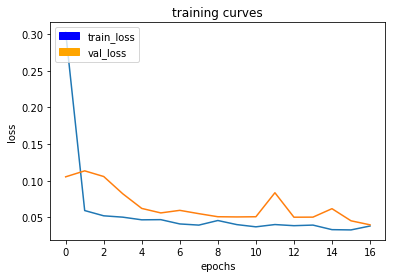

100/100 [==============================] - 77s - loss: 0.0382 - val_loss: 0.0399
Epoch 18/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0353

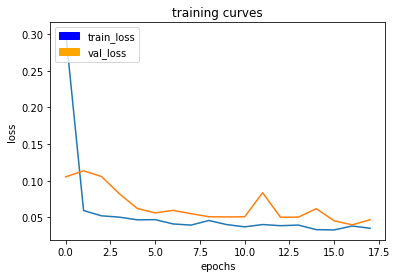

100/100 [==============================] - 77s - loss: 0.0352 - val_loss: 0.0468
Epoch 19/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0355

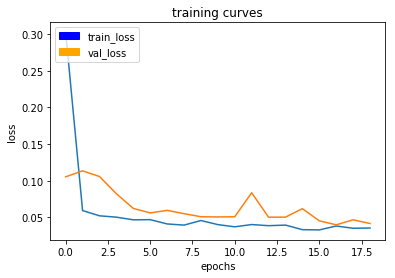

100/100 [==============================] - 77s - loss: 0.0355 - val_loss: 0.0417
Epoch 20/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0332

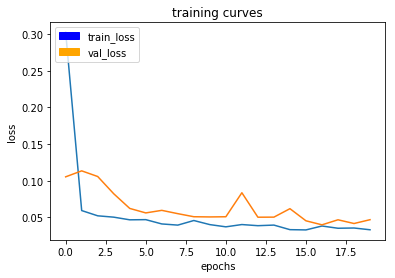

100/100 [==============================] - 76s - loss: 0.0332 - val_loss: 0.0469
Epoch 21/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0349

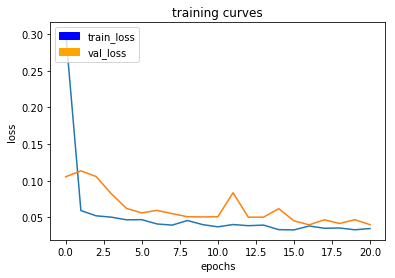

100/100 [==============================] - 77s - loss: 0.0348 - val_loss: 0.0401
Epoch 22/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0337

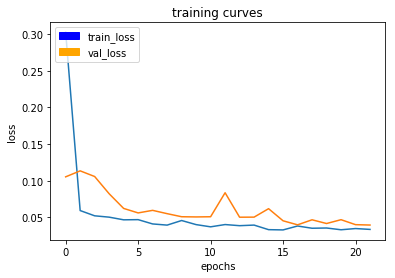

100/100 [==============================] - 77s - loss: 0.0336 - val_loss: 0.0396
Epoch 23/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0332

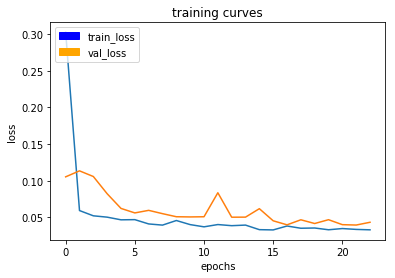

100/100 [==============================] - 77s - loss: 0.0331 - val_loss: 0.0434
Epoch 24/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0309

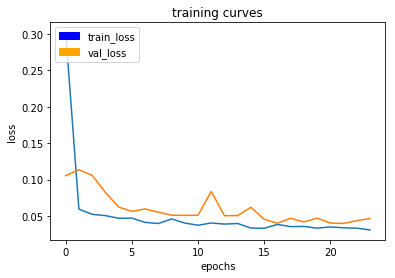

100/100 [==============================] - 77s - loss: 0.0309 - val_loss: 0.0464
Epoch 25/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0362

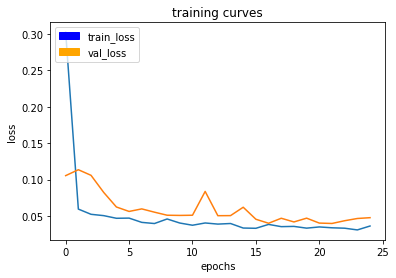

100/100 [==============================] - 77s - loss: 0.0361 - val_loss: 0.0475
Epoch 26/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0317

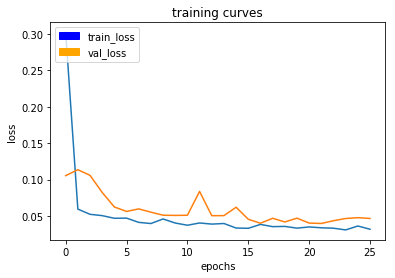

100/100 [==============================] - 77s - loss: 0.0317 - val_loss: 0.0465
Epoch 27/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0341

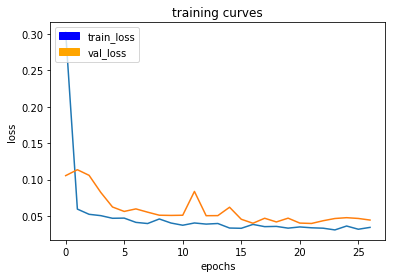

100/100 [==============================] - 76s - loss: 0.0341 - val_loss: 0.0443
Epoch 28/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0289

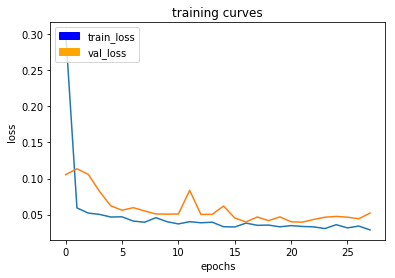

100/100 [==============================] - 77s - loss: 0.0289 - val_loss: 0.0522
Epoch 29/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0334

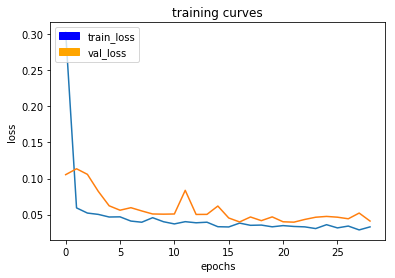

100/100 [==============================] - 76s - loss: 0.0332 - val_loss: 0.0411
Epoch 30/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0326

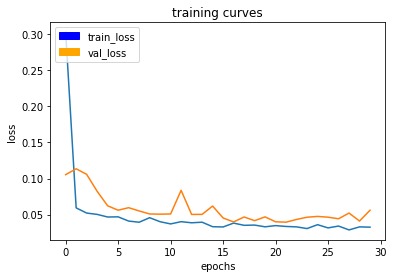

100/100 [==============================] - 77s - loss: 0.0326 - val_loss: 0.0561
Epoch 31/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0317

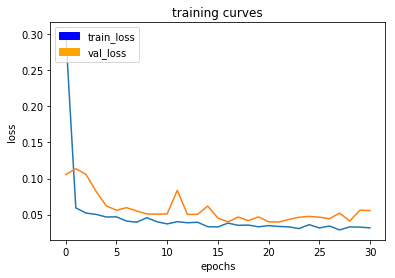

100/100 [==============================] - 77s - loss: 0.0317 - val_loss: 0.0556
Epoch 32/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0312

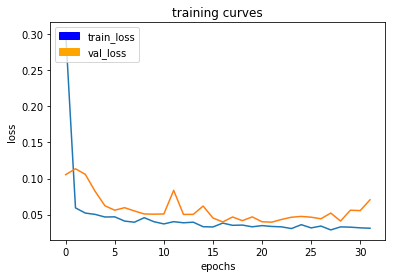

100/100 [==============================] - 77s - loss: 0.0311 - val_loss: 0.0705
Epoch 33/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0295

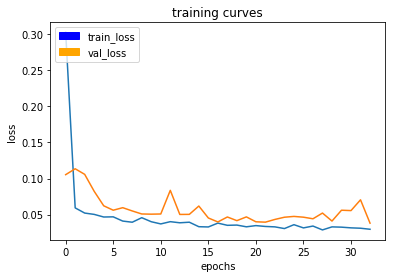

100/100 [==============================] - 77s - loss: 0.0298 - val_loss: 0.0382
Epoch 34/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0333

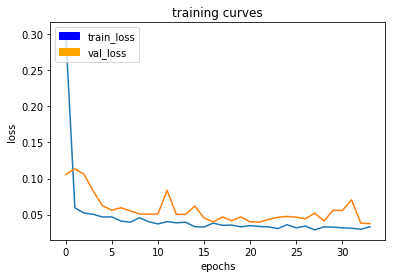

100/100 [==============================] - 76s - loss: 0.0332 - val_loss: 0.0376
Epoch 35/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0288

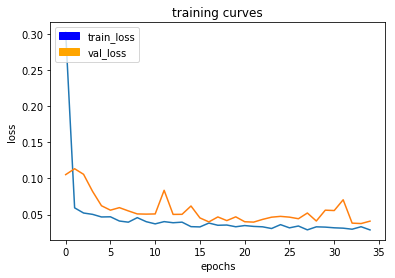

100/100 [==============================] - 76s - loss: 0.0287 - val_loss: 0.0409
Epoch 36/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0309

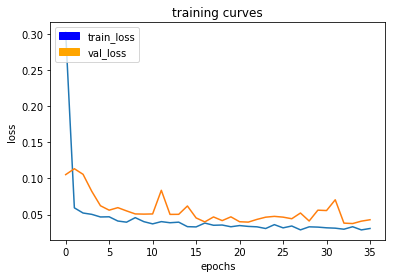

100/100 [==============================] - 77s - loss: 0.0308 - val_loss: 0.0429
Epoch 37/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0297

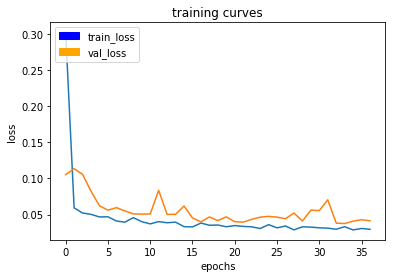

100/100 [==============================] - 76s - loss: 0.0296 - val_loss: 0.0414
Epoch 38/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0297

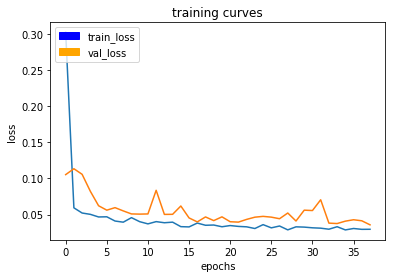

100/100 [==============================] - 77s - loss: 0.0297 - val_loss: 0.0358
Epoch 39/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0273

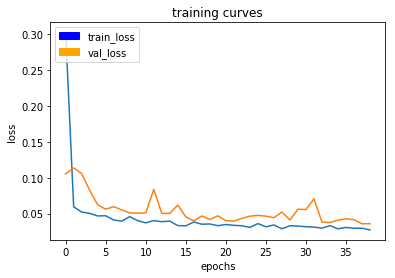

100/100 [==============================] - 76s - loss: 0.0272 - val_loss: 0.0359
Epoch 40/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0317

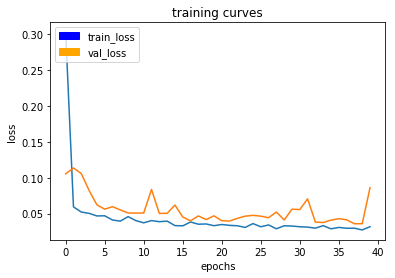

100/100 [==============================] - 77s - loss: 0.0316 - val_loss: 0.0861
Epoch 41/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0310

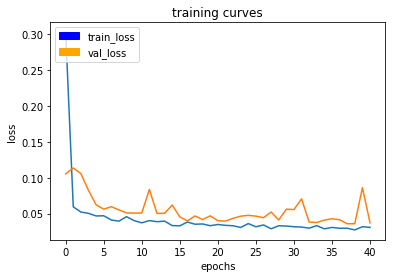

100/100 [==============================] - 78s - loss: 0.0308 - val_loss: 0.0371
Epoch 42/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0296

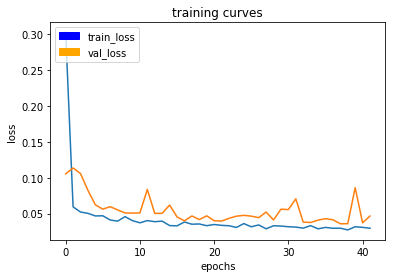

100/100 [==============================] - 76s - loss: 0.0295 - val_loss: 0.0466
Epoch 43/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0289

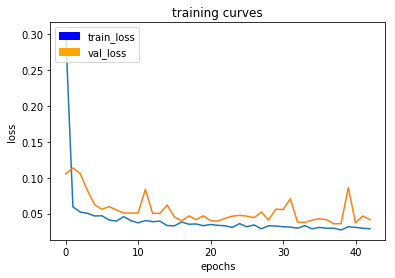

100/100 [==============================] - 77s - loss: 0.0289 - val_loss: 0.0415
Epoch 44/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0299

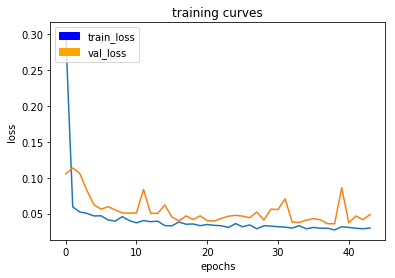

100/100 [==============================] - 77s - loss: 0.0299 - val_loss: 0.0487
Epoch 45/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0275

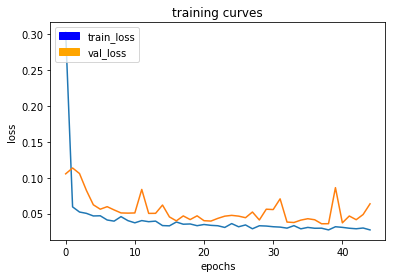

100/100 [==============================] - 76s - loss: 0.0274 - val_loss: 0.0636
Epoch 46/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0274

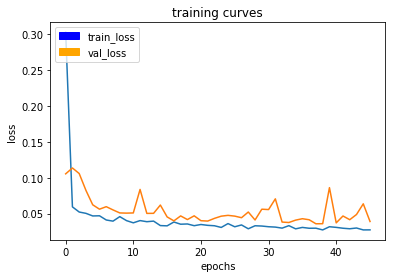

100/100 [==============================] - 76s - loss: 0.0273 - val_loss: 0.0390
Epoch 47/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0303

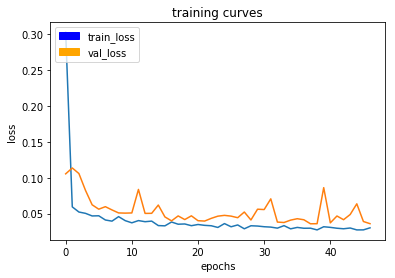

100/100 [==============================] - 76s - loss: 0.0302 - val_loss: 0.0360
Epoch 48/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0285

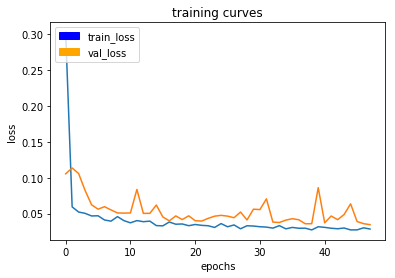

100/100 [==============================] - 77s - loss: 0.0285 - val_loss: 0.0346
Epoch 49/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0278

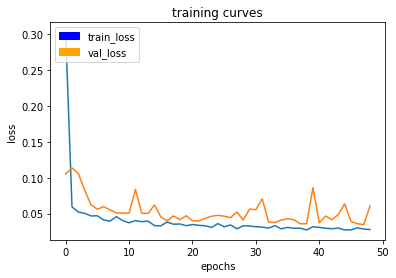

100/100 [==============================] - 76s - loss: 0.0278 - val_loss: 0.0607
Epoch 50/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0286

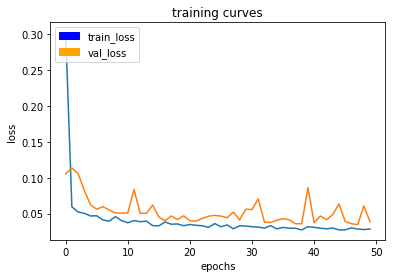

100/100 [==============================] - 77s - loss: 0.0285 - val_loss: 0.0388
Epoch 51/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0282

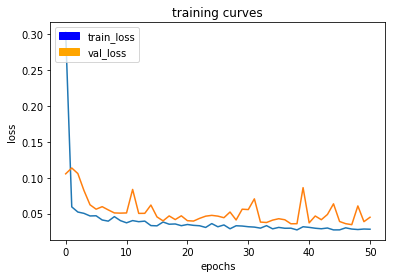

100/100 [==============================] - 77s - loss: 0.0282 - val_loss: 0.0449
Epoch 52/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0296

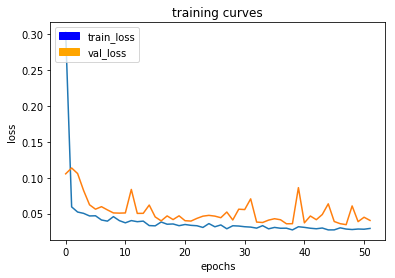

100/100 [==============================] - 77s - loss: 0.0295 - val_loss: 0.0405
Epoch 53/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0285

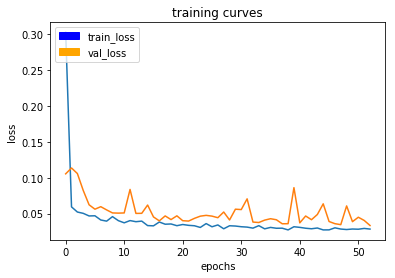

100/100 [==============================] - 77s - loss: 0.0285 - val_loss: 0.0334
Epoch 54/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0260

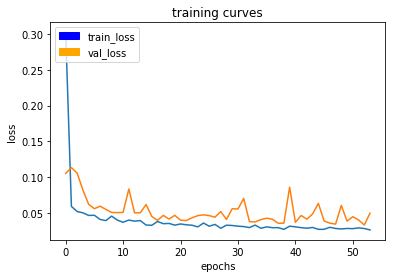

100/100 [==============================] - 76s - loss: 0.0266 - val_loss: 0.0499
Epoch 55/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0295

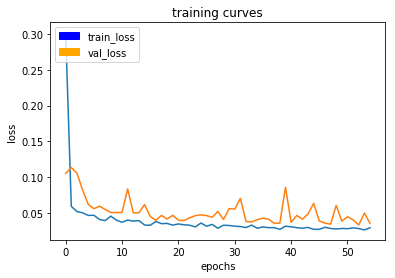

100/100 [==============================] - 76s - loss: 0.0295 - val_loss: 0.0355
Epoch 56/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0283

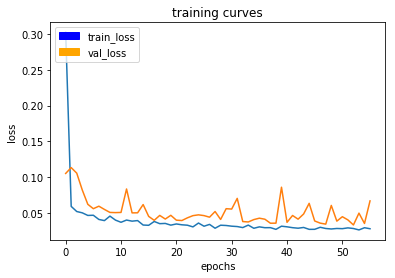

100/100 [==============================] - 76s - loss: 0.0282 - val_loss: 0.0670
Epoch 57/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0318

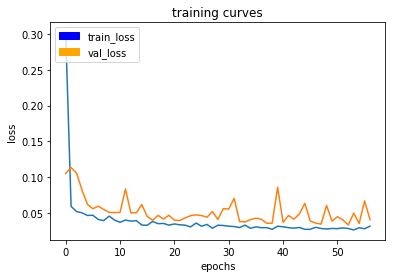

100/100 [==============================] - 76s - loss: 0.0317 - val_loss: 0.0407
Epoch 58/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0270

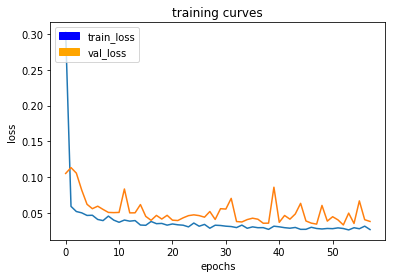

100/100 [==============================] - 77s - loss: 0.0270 - val_loss: 0.0383
Epoch 59/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0276

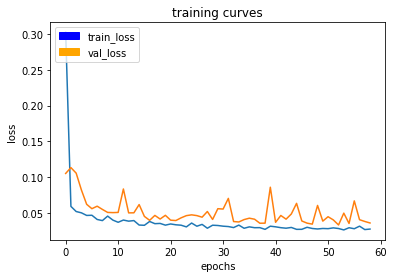

100/100 [==============================] - 77s - loss: 0.0276 - val_loss: 0.0362
Epoch 60/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0280

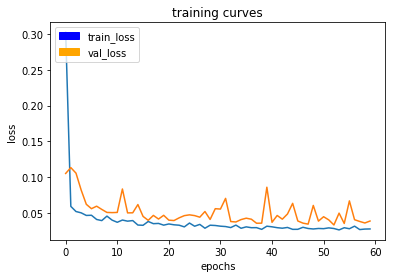

100/100 [==============================] - 76s - loss: 0.0280 - val_loss: 0.0389
Epoch 61/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0272

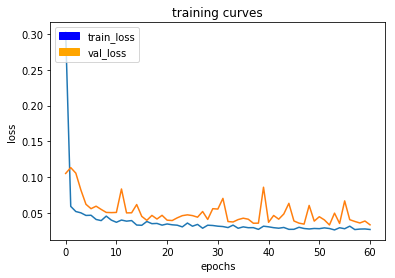

100/100 [==============================] - 77s - loss: 0.0271 - val_loss: 0.0336
Epoch 62/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0298

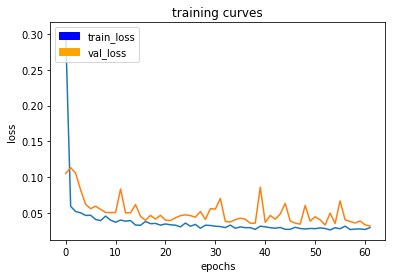

100/100 [==============================] - 76s - loss: 0.0297 - val_loss: 0.0320
Epoch 63/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0264

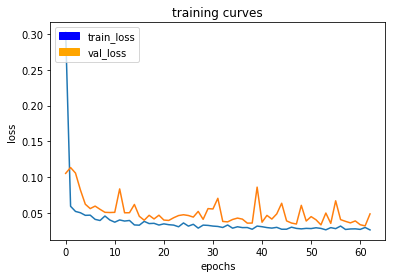

100/100 [==============================] - 77s - loss: 0.0264 - val_loss: 0.0487
Epoch 64/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0283

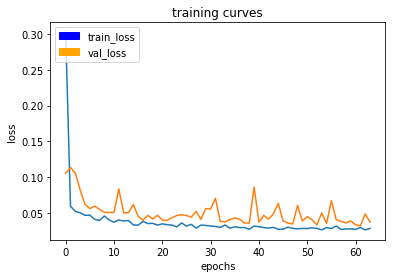

100/100 [==============================] - 77s - loss: 0.0283 - val_loss: 0.0373
Epoch 65/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0281

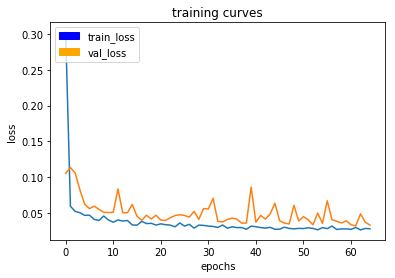

100/100 [==============================] - 77s - loss: 0.0280 - val_loss: 0.0330
Epoch 66/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0262

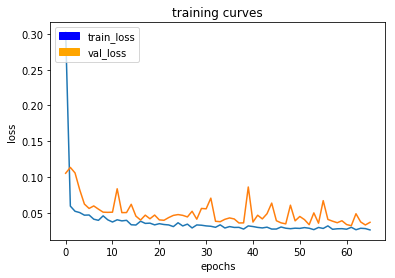

100/100 [==============================] - 77s - loss: 0.0261 - val_loss: 0.0367
Epoch 67/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0266

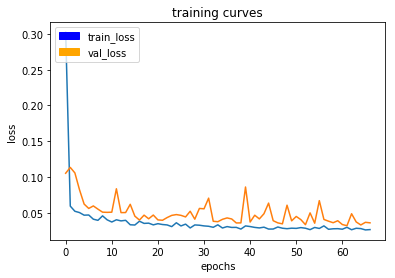

100/100 [==============================] - 77s - loss: 0.0266 - val_loss: 0.0360
Epoch 68/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0268

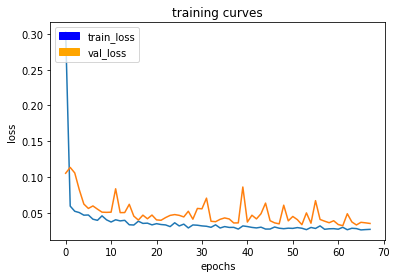

100/100 [==============================] - 77s - loss: 0.0269 - val_loss: 0.0351
Epoch 69/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0282

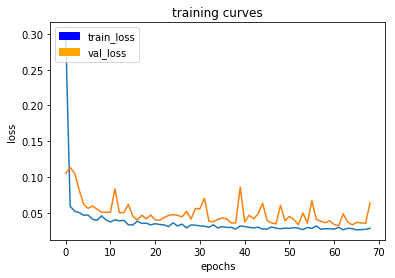

100/100 [==============================] - 77s - loss: 0.0284 - val_loss: 0.0639
Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0254

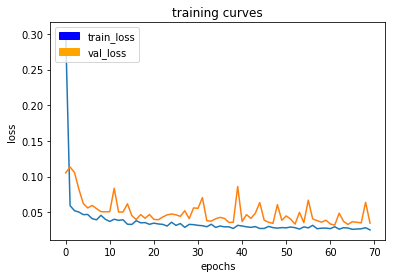

100/100 [==============================] - 77s - loss: 0.0253 - val_loss: 0.0348
Epoch 71/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0266

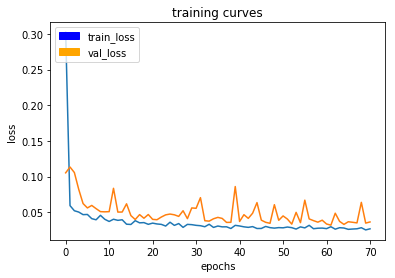

100/100 [==============================] - 77s - loss: 0.0268 - val_loss: 0.0365
Epoch 72/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0263

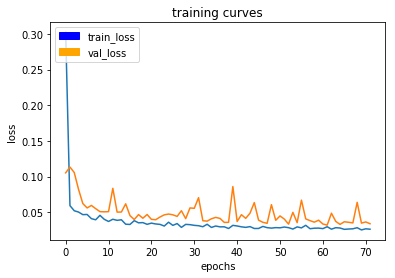

100/100 [==============================] - 77s - loss: 0.0263 - val_loss: 0.0340
Epoch 73/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0263

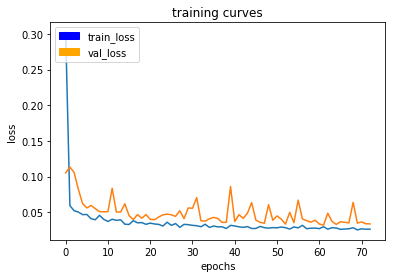

100/100 [==============================] - 77s - loss: 0.0263 - val_loss: 0.0337
Epoch 74/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0279

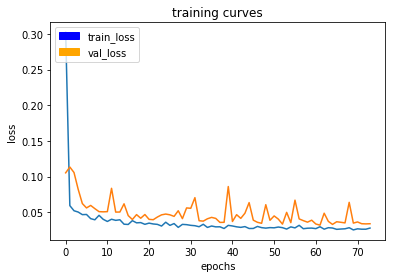

100/100 [==============================] - 77s - loss: 0.0278 - val_loss: 0.0340
Epoch 75/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0262

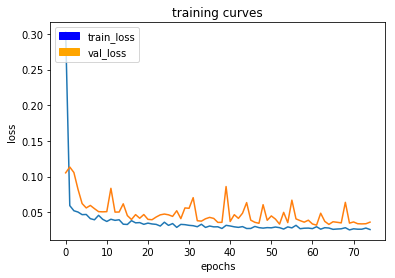

100/100 [==============================] - 77s - loss: 0.0261 - val_loss: 0.0362
Epoch 76/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0254

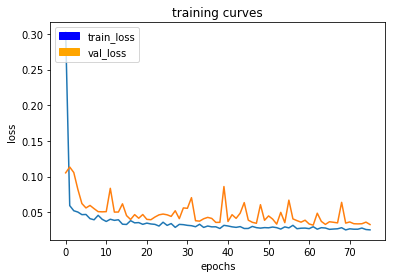

100/100 [==============================] - 77s - loss: 0.0254 - val_loss: 0.0328
Epoch 77/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0264

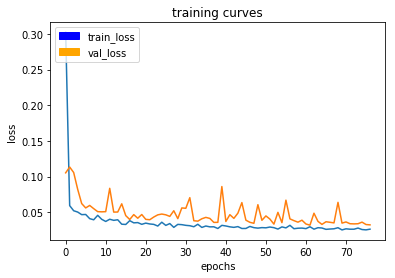

100/100 [==============================] - 76s - loss: 0.0263 - val_loss: 0.0324
Epoch 78/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0269

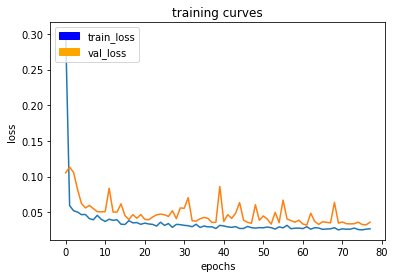

100/100 [==============================] - 77s - loss: 0.0269 - val_loss: 0.0361
Epoch 79/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0266

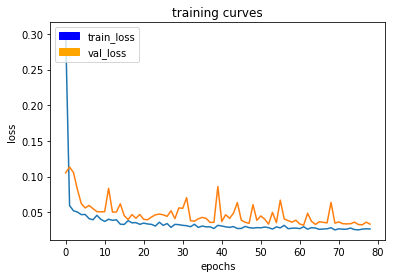

100/100 [==============================] - 77s - loss: 0.0266 - val_loss: 0.0334
Epoch 80/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0259

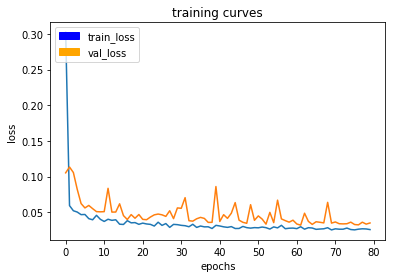

100/100 [==============================] - 77s - loss: 0.0259 - val_loss: 0.0350
Epoch 81/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0256

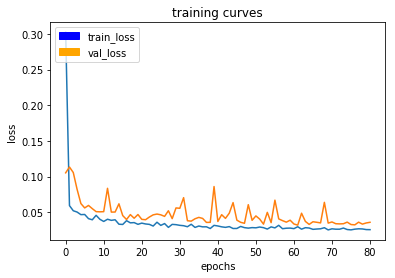

100/100 [==============================] - 77s - loss: 0.0257 - val_loss: 0.0360
Epoch 82/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0243

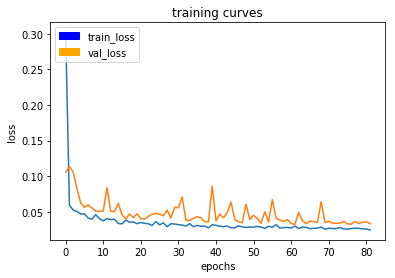

100/100 [==============================] - 77s - loss: 0.0243 - val_loss: 0.0332
Epoch 83/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0269

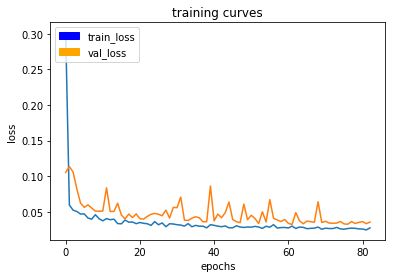

100/100 [==============================] - 77s - loss: 0.0286 - val_loss: 0.0354
Epoch 84/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0283

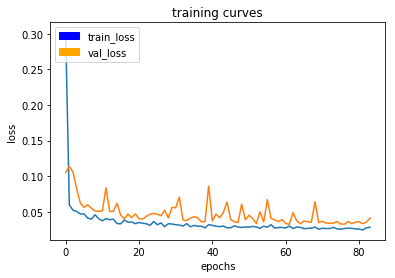

100/100 [==============================] - 78s - loss: 0.0282 - val_loss: 0.0410
Epoch 85/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0242

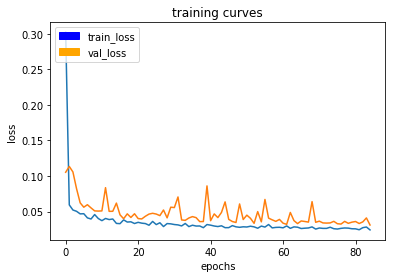

100/100 [==============================] - 76s - loss: 0.0241 - val_loss: 0.0310
Epoch 86/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0265

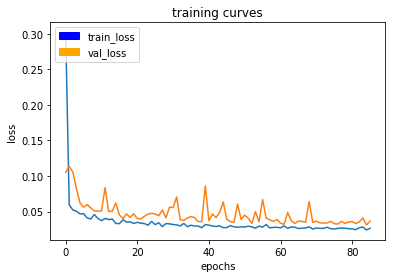

100/100 [==============================] - 77s - loss: 0.0264 - val_loss: 0.0365
Epoch 87/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0259

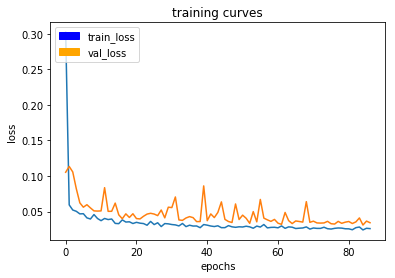

100/100 [==============================] - 77s - loss: 0.0259 - val_loss: 0.0343
Epoch 88/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0246

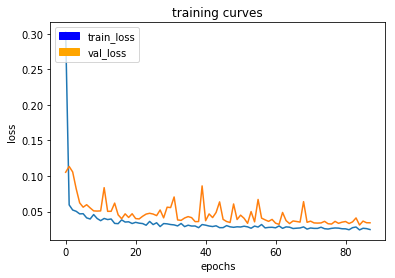

100/100 [==============================] - 77s - loss: 0.0246 - val_loss: 0.0342
Epoch 89/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0250

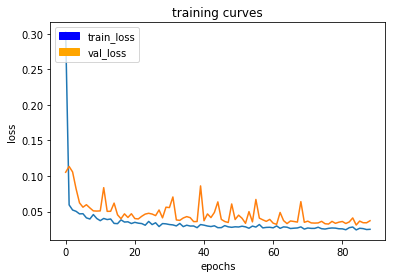

100/100 [==============================] - 77s - loss: 0.0250 - val_loss: 0.0371
Epoch 90/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0260

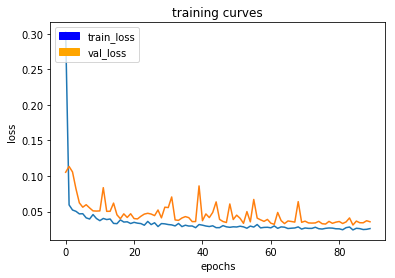

100/100 [==============================] - 77s - loss: 0.0260 - val_loss: 0.0356
Epoch 91/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0264

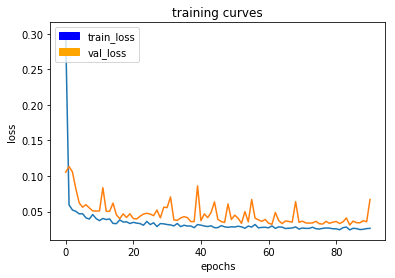

100/100 [==============================] - 77s - loss: 0.0264 - val_loss: 0.0670
Epoch 92/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0263

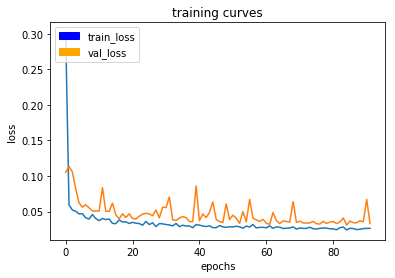

100/100 [==============================] - 77s - loss: 0.0263 - val_loss: 0.0330
Epoch 93/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0236

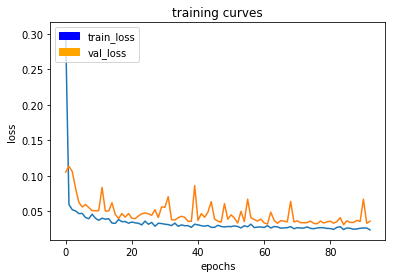

100/100 [==============================] - 77s - loss: 0.0237 - val_loss: 0.0359
Epoch 94/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0248

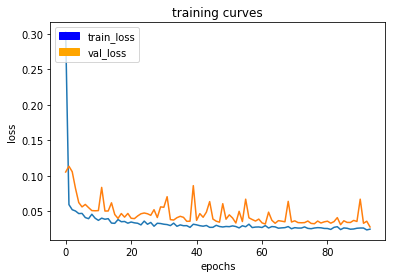

100/100 [==============================] - 77s - loss: 0.0247 - val_loss: 0.0278
Epoch 95/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0256

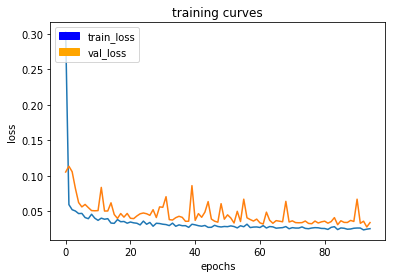

100/100 [==============================] - 77s - loss: 0.0255 - val_loss: 0.0340
Epoch 96/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0263

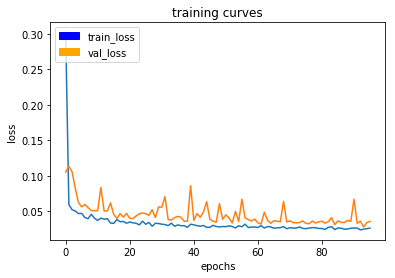

100/100 [==============================] - 77s - loss: 0.0262 - val_loss: 0.0358
Epoch 97/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0235

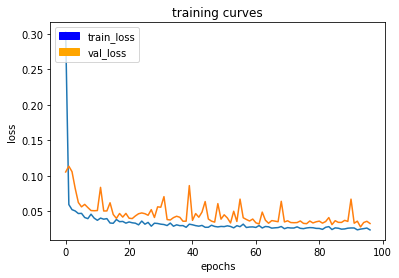

100/100 [==============================] - 77s - loss: 0.0235 - val_loss: 0.0326
Epoch 98/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0270

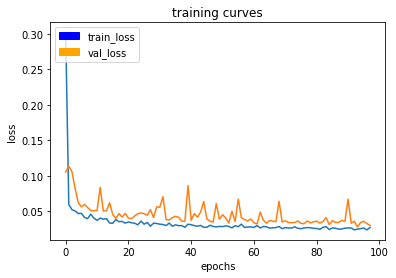

100/100 [==============================] - 77s - loss: 0.0270 - val_loss: 0.0299
Epoch 99/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0255

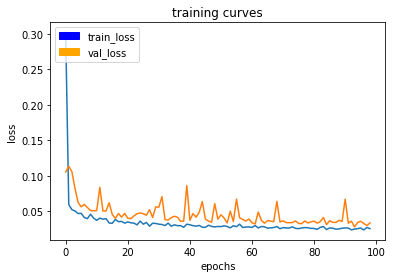

100/100 [==============================] - 77s - loss: 0.0254 - val_loss: 0.0334
Epoch 100/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0236

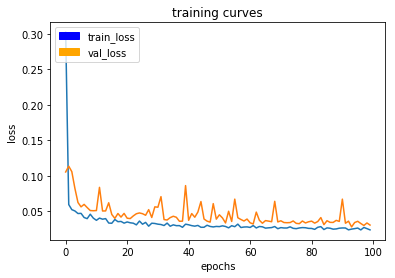

100/100 [==============================] - 77s - loss: 0.0237 - val_loss: 0.0304


In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]
    model.summary()
    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [30]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [18]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

#weight_file_name = 'model_weights'
#restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [19]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

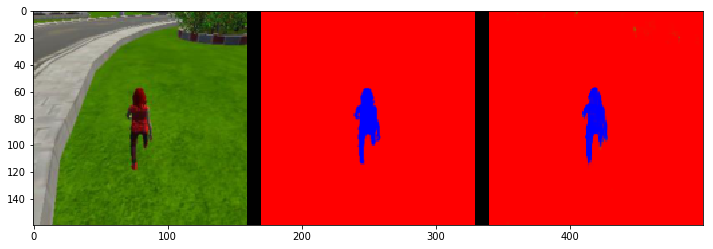

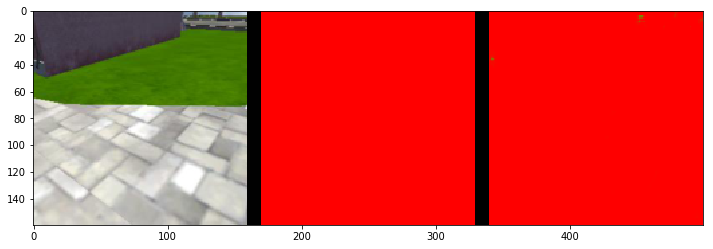

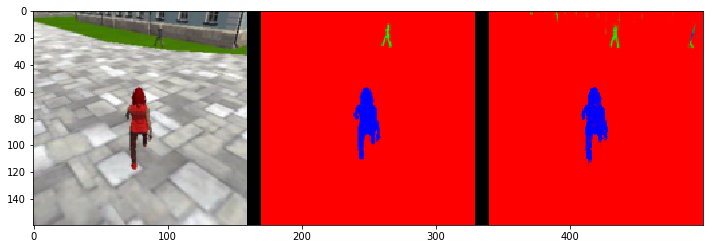

In [20]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

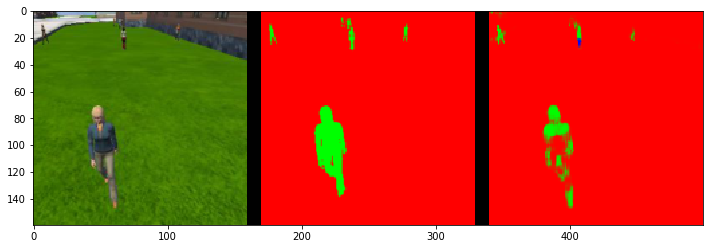

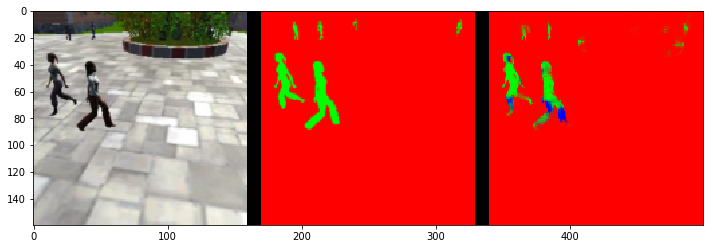

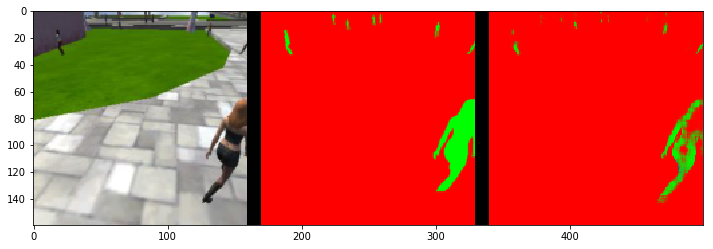

In [21]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

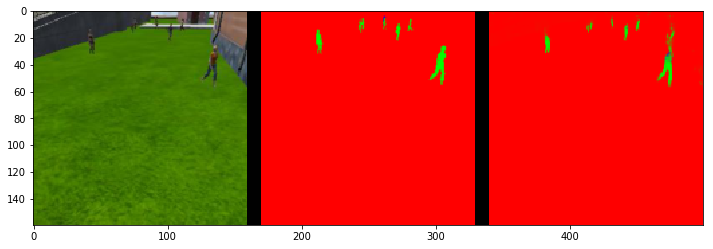

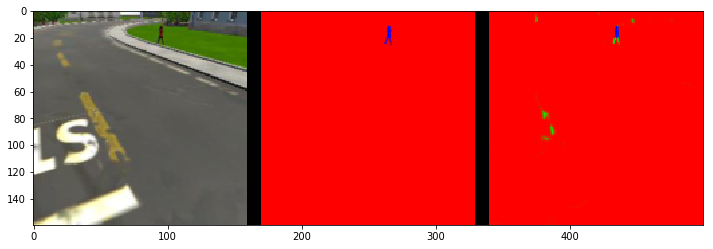

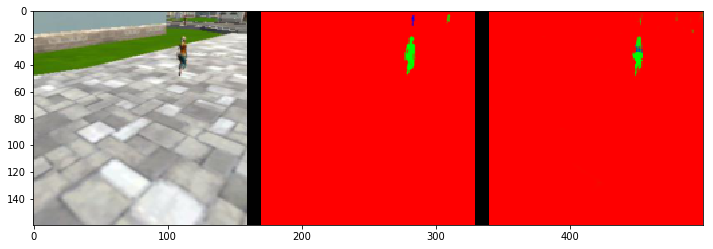

In [22]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [23]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9940888534220996
average intersection over union for other people is 0.32053393449106177
average intersection over union for the hero is 0.8766022651961956
number true positives: 539, number false positives: 1, number false negatives: 0


In [24]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9754854859791642
average intersection over union for other people is 0.475637446078192
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 146, number false negatives: 0


In [25]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9952377371143032
average intersection over union for other people is 0.4074451737588347
average intersection over union for the hero is 0.2823717431450294
number true positives: 183, number false positives: 5, number false negatives: 118


In [26]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7278225806451613


In [27]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.579487004171


In [28]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.421763726826


In [29]:
print(final_score)

0.421763726826
